In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(filenames)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Custom Object Detector with Detectron2

In [3]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 5.5 MB/s eta 0:00:00a 0:00:01
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15912, done.
remote: Total 15912 (delta 0), reused 0 (delta 0), pack-reused 15912 (from 1)
Receiving objects: 100% (15912/15912), 6.68 MiB | 20.85 MiB/s, done.
Resolving deltas: 100% (11329/11329), done.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your environment
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.1 MB/s eta 0:00:00

In [4]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
torch:  2.6 ; cuda:  cu124
detectron2: 0.6


##### Imports

In [5]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os,json,random
import cv2 as cv

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog,DatasetCatalog

#### Dataset
https://universe.roboflow.com/joseph-nelson/hard-hat-workers/dataset/10

#### Register Dataset

In [6]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances('exp_train',{},'/kaggle/input/hard-hat-workersraw-allclasses-coco/train/_annotations.coco.json','/kaggle/input/hard-hat-workersraw-allclasses-coco/train/')
register_coco_instances('exp_val',{},'/kaggle/input/hard-hat-workersraw-allclasses-coco/valid/_annotations.coco.json','/kaggle/input/hard-hat-workersraw-allclasses-coco/valid/')
register_coco_instances('exp_test',{},'/kaggle/input/hard-hat-workersraw-allclasses-coco/test/_annotations.coco.json','/kaggle/input/hard-hat-workersraw-allclasses-coco/test/')

WARNING [09/03 07:25:51 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/03 07:25:51 d2.data.datasets.coco]: Loaded 4916 images in COCO format from /kaggle/input/hard-hat-workersraw-allclasses-coco/train/_annotations.coco.json


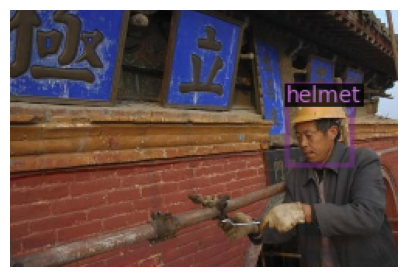

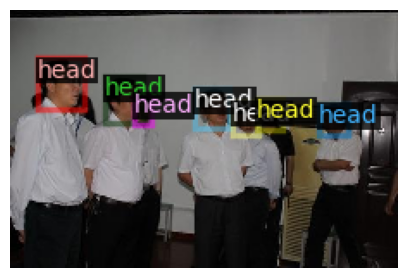

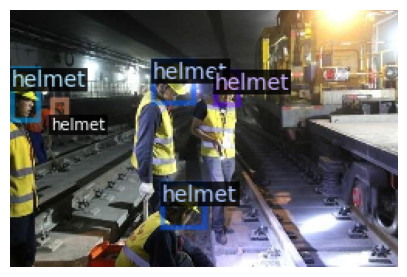

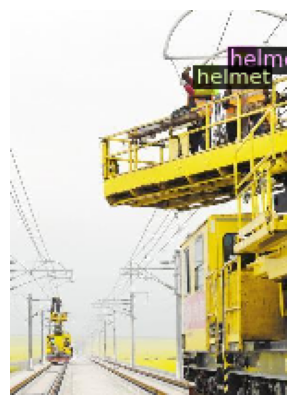

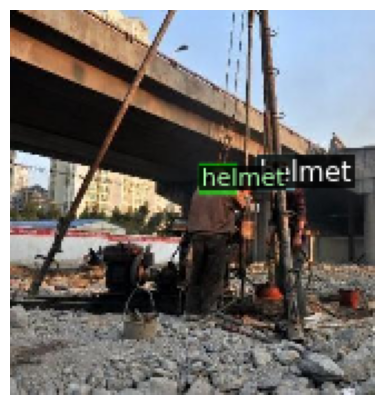

In [7]:
# visualize training data
my_dataset_train_metadata = MetadataCatalog.get('exp_train')
dataset_dicts = DatasetCatalog.get('exp_train')

import random
from detectron2.utils.visualizer import Visualizer
from matplotlib import pyplot as plt

for d in random.sample(dataset_dicts,5):
    img = cv.imread(d['file_name'])
    visualizer = Visualizer(img[:,:,::-1],metadata=my_dataset_train_metadata,scale=0.5)
    vis = visualizer.draw_dataset_dict(d)

    plt.figure(figsize=(5,5))
    plt.imshow(vis.get_image())
    plt.axis('off')
    plt.show()
    

##### Model Training

In [8]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file('COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml'))
cfg.DATASETS.TRAIN = ('exp_train')
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url('COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml')
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.CHECKPOINT_PERIOD = 100
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
cfg.OUTPUT_DIR = '/kaggle/working/detectron2_output'
os.makedirs(cfg.OUTPUT_DIR,exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[09/03 07:25:53 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:00, 220MB/s]                               


[09/03 07:25:55 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[09/03 07:26:07 d2.utils.events]:  eta: 0:06:24  iter: 19  total_loss: 1.777  loss_cls: 1.399  loss_box_reg: 0.3165  loss_rpn_cls: 0.1281  loss_rpn_loc: 0.0306    time: 0.3928  last_time: 0.4087  data_time: 0.0114  last_data_time: 0.0046   lr: 4.9952e-05  max_mem: 2585M


2025-09-03 07:26:11.678538: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756884372.049536      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756884372.156358      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[09/03 07:26:35 d2.utils.events]:  eta: 0:06:13  iter: 39  total_loss: 1.619  loss_cls: 0.9329  loss_box_reg: 0.5807  loss_rpn_cls: 0.06689  loss_rpn_loc: 0.02723    time: 0.3925  last_time: 0.3506  data_time: 0.0053  last_data_time: 0.0049   lr: 9.9902e-05  max_mem: 2585M
[09/03 07:26:43 d2.utils.events]:  eta: 0:06:08  iter: 59  total_loss: 1.228  loss_cls: 0.5788  loss_box_reg: 0.5655  loss_rpn_cls: 0.02689  loss_rpn_loc: 0.01391    time: 0.3957  last_time: 0.3329  data_time: 0.0052  last_data_time: 0.0052   lr: 0.00014985  max_mem: 2585M
[09/03 07:26:51 d2.utils.events]:  eta: 0:06:03  iter: 79  total_loss: 1.266  loss_cls: 0.4431  loss_box_reg: 0.7804  loss_rpn_cls: 0.02392  loss_rpn_loc: 0.01754    time: 0.3987  last_time: 0.4020  data_time: 0.0055  last_data_time: 0.0043   lr: 0.0001998  max_mem: 2585M
[09/03 07:26:59 d2.utils.events]:  eta: 0:05:56  iter: 99  total_loss: 1.22  loss_cls: 0.365  loss_box_reg: 0.7873  loss_rpn_cls: 0.02545  loss_rpn_loc: 0.01433    time: 0.3983  l

FileNotFoundError: [Errno 2] No such file or directory: 'datasets/coco/annotations/instances_val2017.json'

In [10]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR,'model_final.pth')
cfg.MODEL.ROI_HEADS_SCORE_THRESH_TEST = 0.5
cfg.DATASETS.TEST = ('exp_train')
predictor = DefaultPredictor(cfg)

[09/03 07:37:29 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /kaggle/working/detectron2_output/model_final.pth ...


#### Visualizing Results

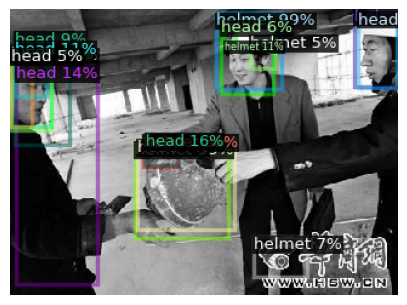

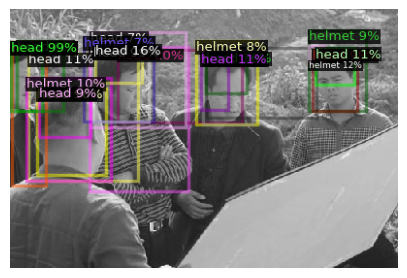

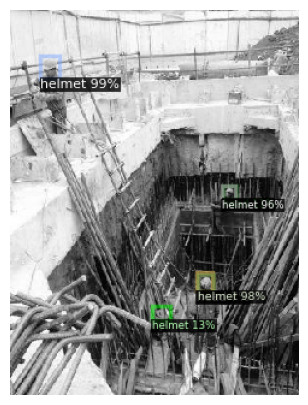

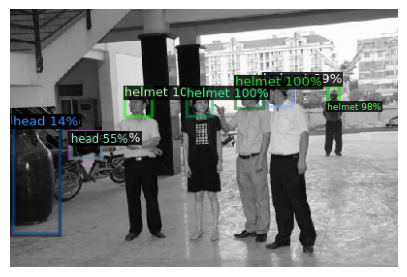

In [12]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts,4):
    im = cv.imread(d['file_name'])
    outputs = predictor(im)
    v = Visualizer(im[:,:,::-1],
                  metadata=my_dataset_train_metadata,
                  scale=0.8,
                  instance_mode=ColorMode.IMAGE_BW
                  )
    v = v.draw_instance_predictions(outputs['instances'].to('cpu'))
    plt.figure(figsize=(5,5))
    plt.imshow(v.get_image()[:,:,::-1])
    plt.axis('off')
    plt.show()

#### Evaluation

In [13]:
from detectron2.evaluation import COCOEvaluator,inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator('exp_test',output_dir='/kaggle/working/detectron2_eval')
val_loader = build_detection_test_loader(cfg,'exp_test')
print(inference_on_dataset(predictor.model,val_loader,evaluator))

[09/03 07:46:26 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [09/03 07:46:26 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/03 07:46:26 d2.data.datasets.coco]: Loaded 706 images in COCO format from /kaggle/input/hard-hat-workersraw-allclasses-coco/test/_annotations.coco.json
[09/03 07:46:26 d2.data.build]: Distribution of instances among all 4 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|  Workers   | 0            |    head    | 726          |   helmet   | 1915         |
|   person   | 64           |            |              |            |              |
|   total    | 2705         |            |              |            |              |
[09/03 07:46:26 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in in

##### Getting the custom config file

In [14]:
f = open('/kaggle/working/detectron2_output/config.yml', 'w')
f.write(cfg.dump())
f.close()
